# News Sentiment Analysis
The following is a demonstration of a Target-dependent Sentiment Classifier (TSC) on Maltese news articles. It uses a Hamborg's [BERT-based model](https://huggingface.co/fhamborg/roberta-targeted-sentiment-classification-newsarticles) trained on the [NewsMTSC](https://github.com/fhamborg/NewsMTSC) dataset.

This demonstration processes news articles from various Maltese newspapers, classifies the sentiment towards specific targets, and visualises the results.
The data is visualised in two ways:
1. **Aggregate Chart**: The `get_aggregate_sentiment` function generates an aggregate sentiment chart for a given target over time.
2. **Grouped by Newspaper**: The `get_grouped_sentiment` function generates sentiment charts grouped by newspaper, allowing for a comparison of sentiment across different sources.

The helper program sentiment/target_sentiment_classifier.py performs Named Entity Recognition (NER) using multiprocessing(*), then performs TSC on the detected entities.


(*) Running multi-processing programs may not work on Google Colab.

In [1]:
import os
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sentiment.target_sentiment_classifier import NER, TSC

### Import the data

In [2]:
df = pd.read_csv(os.path.join("D:","vectordb_data","data.csv"))
df['date'] = pd.to_datetime(df['date'],format="%d-%m-%Y")

#Only keep articles last modified in 2024
df = df[df['date'].apply(lambda d: d.year == 2024)].reset_index(drop=True)

### Text Sentiment
Perform Named Entity Recoginiton (NER) and store the results.  
_NOTE: Costly operation_

In [3]:
ner = NER()
ner_tags = ner.classify(df['title'],cpu_count=4)

with open(os.path.join("sentiment","ner_tags.pkl"), "wb") as f:
    pickle.dump(ner_tags, f)

# with open(os.path.join("sentiment","ner_tags.pkl"), "rb") as f:
#     ner_tags = pickle.load(f)

### Define function to perform TSC and visualise the data.

In [4]:
def get_data(targets, verbose:bool=False):
    targets = [t.upper() for t in targets]

    idx_tags = [(i,tags[j])
                for i,tags in enumerate(ner_tags)
                for j,tag in enumerate(tags)
                if tag['text'].upper() in targets]

    tsc = TSC()
    tsc_tags = [(df['title'].iloc[i].replace('’',"'"),t) for i,t in idx_tags]
    
    if verbose:
        print(*tsc_tags,sep='\n')

    tsc_tags = tsc.classify(
        tsc_tags
    )

    #Standardise every element to [negative,neutral,positive] 
    tsc_tags_2 = []
    for tag in tsc_tags:
        sentiment = [None]*3
        for s in tag:
            sentiment[s['class_id']] = round(s['class_prob'],3)
        tsc_tags_2.append(sentiment)    

    tsc_tags = tsc_tags_2
    del tsc_tags_2

    data = [(df['newspaper'].iloc[i],
            df['date'].iloc[i],
            tsc_tags[j]) for j,(i,_) in enumerate(idx_tags)]

    return data
def get_aggregate_sentiment(targets:list[str], target_name:str, y_lim:int=25, verbose:bool=False):
    assert targets and target_name     

    data = get_data(targets,verbose=verbose)
    df_2 = pd.DataFrame(data, columns=['newspaper', 'date', 'sentiment_scores'])
    df_2[['neg', 'neut', 'pos']] = pd.DataFrame(df_2['sentiment_scores'].tolist(), index=df_2.index)

    # Group by Week
    df_2['date'] = df_2['date'].dt.to_period('W').apply(lambda r: r.start_time)
    df_2 = df_2.groupby('date')[['neg', 'neut', 'pos']].sum().reset_index()

    #Ensure all weeks in the range are present
    all_weeks = pd.date_range(start='2024-01-01', end='2024-12-31', freq='W-MON')
    df_2 = df_2.set_index('date').reindex(all_weeks).fillna(0).rename_axis('date').reset_index()

    # Group by Day
    # df_2 = df_2.groupby('date')[['neg', 'neut', 'pos']].sum().reset_index()
    sns.set_theme(rc={'figure.figsize':(17,6)},font="Bahnschrift",style='ticks')
    fig, ax = plt.subplots()

    #This is just for plotting
    df_2['date_index'] = range(len(df_2['date']))
    bar_width = 0.9

    ax.bar(df_2['date_index'], df_2['neg'], width=bar_width, label='Negative', color='red', align='center')
    ax.bar(df_2['date_index'], df_2['neut'], width=bar_width, bottom=df_2['neg'], label='Neutral', color='rebeccapurple', align='center')
    ax.bar(df_2['date_index'], df_2['pos'], width=bar_width, bottom=df_2['neg'] + df_2['neut'], label='Positive', color='green', align='center')

    ax.set_title(f'Sentiment towards {target_name}', fontsize=17,pad=20)
    ax.text(0.5, 1.02, f'Based on analysis of the following named entities: {str(targets)[1:-1]}', 
        horizontalalignment='center',
        transform=ax.transAxes,
        fontsize=10,
        color='gray')

    ax.set_xlabel('Date'           , fontsize=14)
    ax.set_ylabel('Times Mentioned', fontsize=14)
    ax.legend(title='Sentiment', loc='upper left')

    yticks = range(0,y_lim+1,1)
    ax.set_ylim(0, y_lim+1)
    ax.set_yticks(yticks)
    ax.set_yticklabels(labels=yticks,fontsize=12)


    #Show the labels of `date` instead of `date_index`
    ax.set_xticks(df_2['date_index'])
    ax.set_xticklabels(df_2['date'].dt.strftime('%b'), rotation=90, fontsize=12)

    plt.tight_layout()
    plt.margins(x=0.01)
    plt.grid()
    plt.show()

    return
def get_grouped_sentiment(targets:list[str],target_name:str,y_lim:int=25, verbose:bool=False):

    assert targets and target_name     
    data = get_data(targets,verbose=verbose)

    df_2 = pd.DataFrame(data, columns=['newspaper', 'date', 'sentiment_scores'])
    df_2[['neg', 'neut', 'pos']] = pd.DataFrame(df_2['sentiment_scores'].tolist(), index=df_2.index)

    # Group by Week
    df_2['date'] = df_2['date'].dt.to_period('W').apply(lambda r: r.start_time)

    newspaper2label = {
        "timesofmalta": "Times of Malta",
        "maltatoday": "Malta Today",
        "independent": "The Independent",
        "theshiftnews": "The Shift News",
        "newsbook": "Newsbook"
    }

    # Split each newspaper into its own dataframe
    dfs = {newspaper: df_2[df_2['newspaper'] == newspaper].reset_index(drop=True)
        for newspaper in df_2['newspaper'].unique()}

    dfs = {newspaper: df_2.groupby('date')[['neg', 'neut', 'pos']].sum().reset_index()
        for newspaper, df_2 in dfs.items()}

    # Ensure all weeks in the range are present
    all_weeks = pd.date_range(start='2024-01-01', end='2024-12-31', freq='W-MON')
    dfs = {newspaper: df_2.set_index('date').reindex(all_weeks).fillna(0).rename_axis('date').reset_index()
        for newspaper, df_2 in dfs.items()}
    
    #Re-order
    dfs = {newspaper: dfs[newspaper] for newspaper in newspaper2label.keys() if newspaper in dfs}

    fig, axs = plt.subplots(len(dfs), 1, figsize=(12, 3 * len(dfs)), sharex=False)

    for i, (newspaper, df_2) in enumerate(dfs.items()):
        ax = axs[i]
        sns.set_theme(rc={'figure.figsize': (12, 3)}, font="Bahnschrift", style='ticks')

        # This is just for plotting
        df_2['date_index'] = range(len(df_2['date']))
        bar_width = 0.9

        ax.bar(df_2['date_index'], df_2['neg'], width=bar_width, label='Negative', color='red', align='center')
        ax.bar(df_2['date_index'], df_2['neut'], width=bar_width, bottom=df_2['neg'], label='Neutral', color='rebeccapurple', align='center')
        ax.bar(df_2['date_index'], df_2['pos'], width=bar_width, bottom=df_2['neg'] + df_2['neut'], label='Positive', color='green', align='center')

        if i == 0:
            ax.set_title(f'Sentiment towards {target_name}', fontsize=17, pad=20)
            ax.text(0.5, 1.03, f'Based on analysis of the following named entities: {str(targets)[1:-1]}',
                    horizontalalignment='center',
                    transform=ax.transAxes,
                    fontsize=10,
                    color='gray')
            ax.legend(title='Sentiment', loc='upper left', fontsize=8)

        ax.set_title(f'{newspaper2label[newspaper]}', fontsize=17, pad=20, loc='left', color='white', backgroundcolor='red', x=0.00, y=0.85)
        
        if i == len(newspaper)-1:
            ax.set_xlabel('Date', fontsize=14)
            ax.set_ylabel('Times Mentioned', fontsize=14)

        y_lim = 15
        yticks = range(0, y_lim + 1, 1)
        ax.set_ylim(0, y_lim + 1)
        ax.set_yticks(yticks)
        ax.set_yticklabels(labels=yticks, fontsize=11)

        # Show the labels of `date` instead of `date_index`
        ax.set_xticks(df_2['date_index'])
        ax.set_xticklabels(df_2['date'].dt.strftime('%b'), rotation=90, fontsize=12)
        ax.margins(x=0.01)
        ax.grid()

    plt.tight_layout()
    plt.show()

#### Aggregate Chart

c:\Users\User\anaconda3\envs\sentiment\Lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Processing batches: 100%|██████████| 323/323 [00:09<00:00, 33.54batch/s]


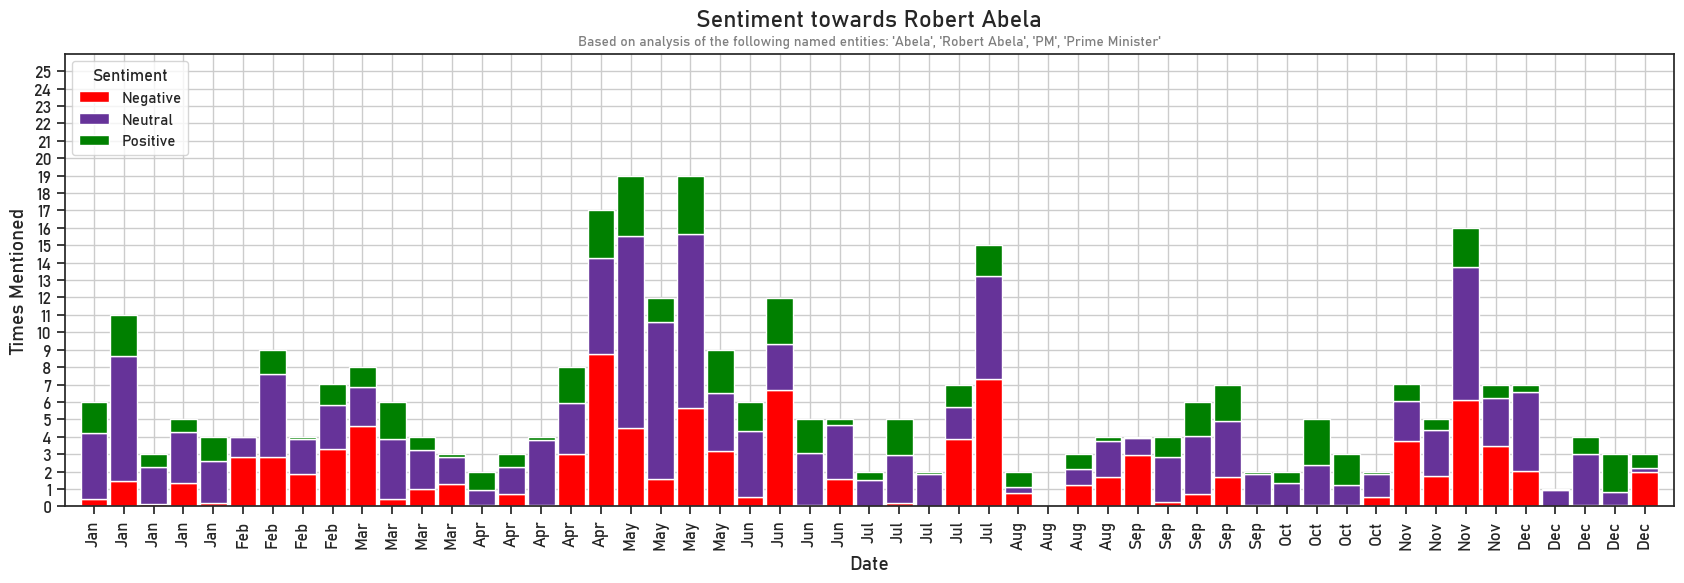

c:\Users\User\anaconda3\envs\sentiment\Lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Processing batches: 100%|██████████| 149/149 [00:03<00:00, 38.64batch/s]


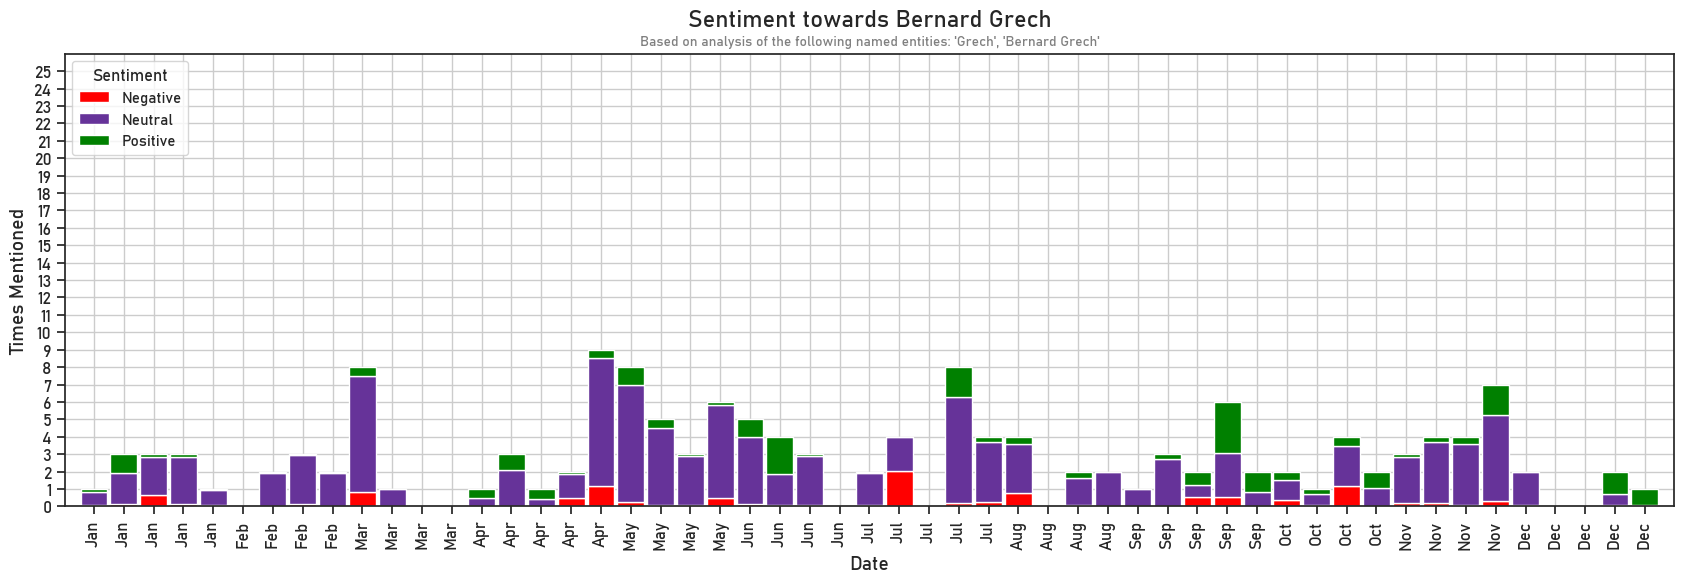

c:\Users\User\anaconda3\envs\sentiment\Lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Processing batches: 100%|██████████| 69/69 [00:02<00:00, 34.11batch/s]


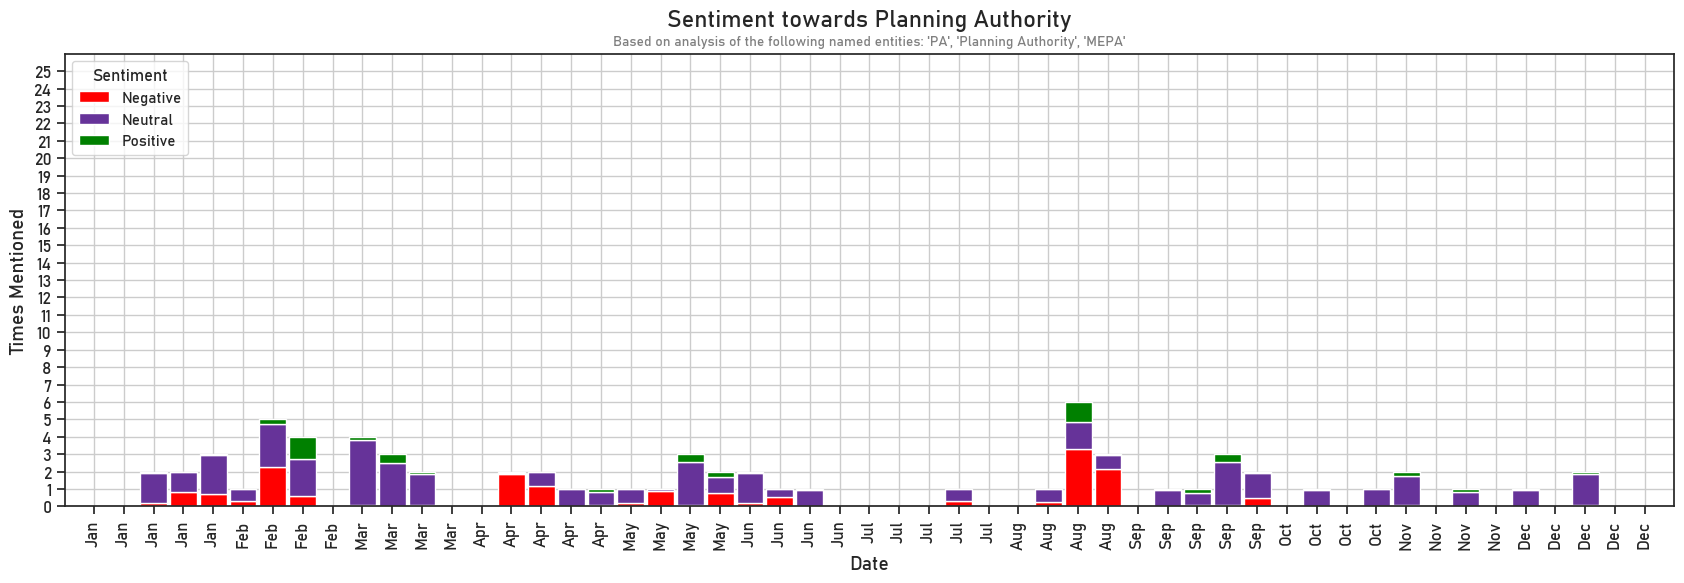

c:\Users\User\anaconda3\envs\sentiment\Lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Processing batches: 100%|██████████| 227/227 [00:06<00:00, 37.08batch/s]


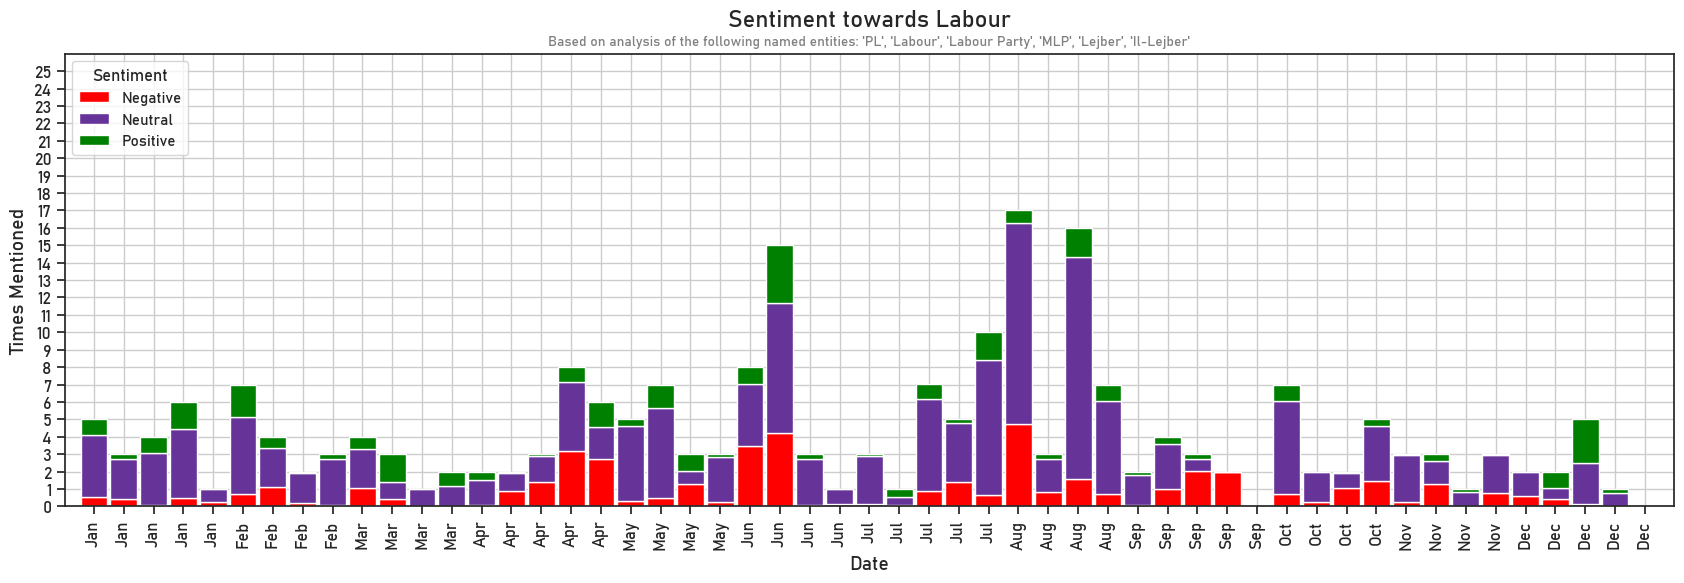

c:\Users\User\anaconda3\envs\sentiment\Lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Processing batches: 100%|██████████| 409/409 [00:11<00:00, 36.03batch/s]


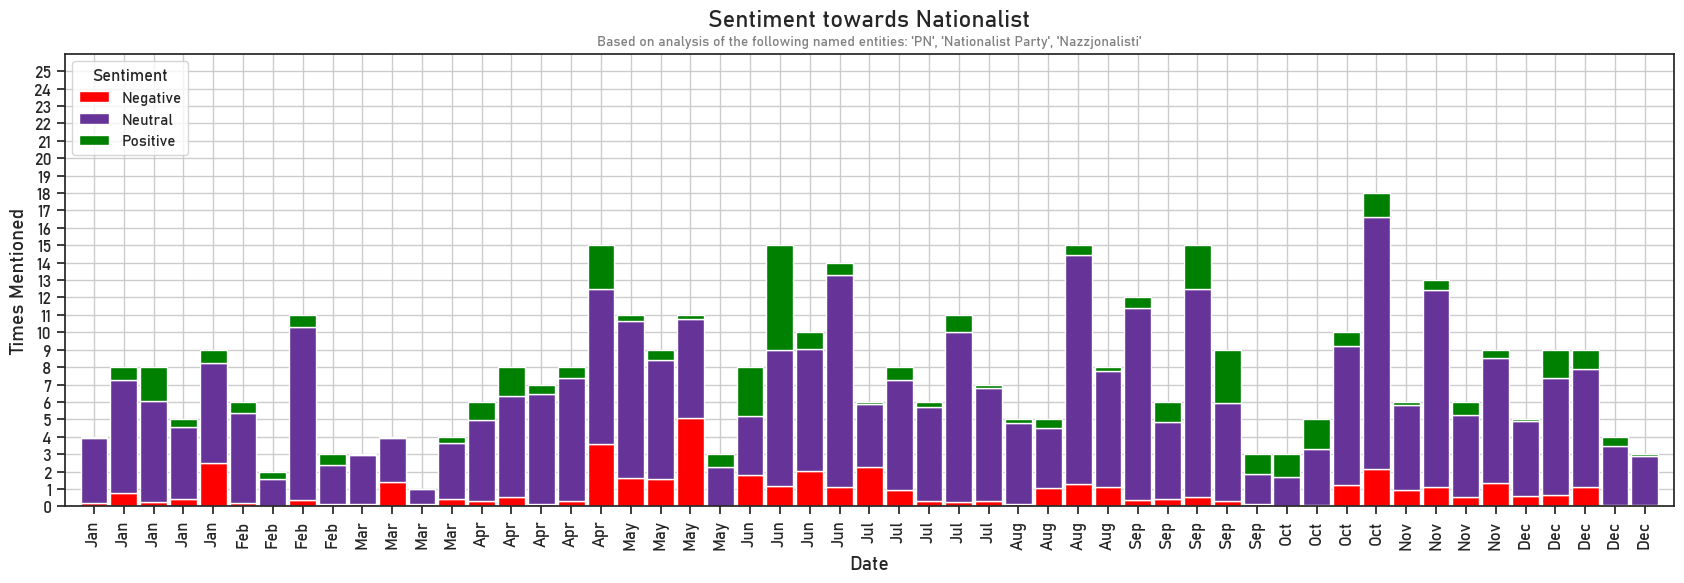

In [5]:
# targets = ["PA","Planning Authority","MEPA"]
# targets = ["PL","Labour","Labour Party","MLP","Lejber","Il-Lejber"]
# targets = ["PN","Nationalist Party","Nazzjonalisti"]
# targets = ["Grech","Bernard Grech"]

get_aggregate_sentiment(
    targets=["Abela", "Robert Abela", "PM", "Prime Minister"],
    target_name="Robert Abela"
)

get_aggregate_sentiment(
    targets=["Grech","Bernard Grech"],
    target_name="Bernard Grech"
)

get_aggregate_sentiment(
    targets=["PA","Planning Authority","MEPA"],
    target_name="Planning Authority"
)

get_aggregate_sentiment(
    targets=["PL","Labour","Labour Party","MLP","Lejber","Il-Lejber"],
    target_name="Labour"
)

get_aggregate_sentiment(
    targets=["PN","Nationalist Party","Nazzjonalisti"],
    target_name="Nationalist"
)




#### Grouped by Newspaper

c:\Users\User\anaconda3\envs\sentiment\Lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Processing batches:  10%|█         | 33/323 [00:00<00:07, 39.09batch/s]

Processing batches: 100%|██████████| 323/323 [00:08<00:00, 38.93batch/s]


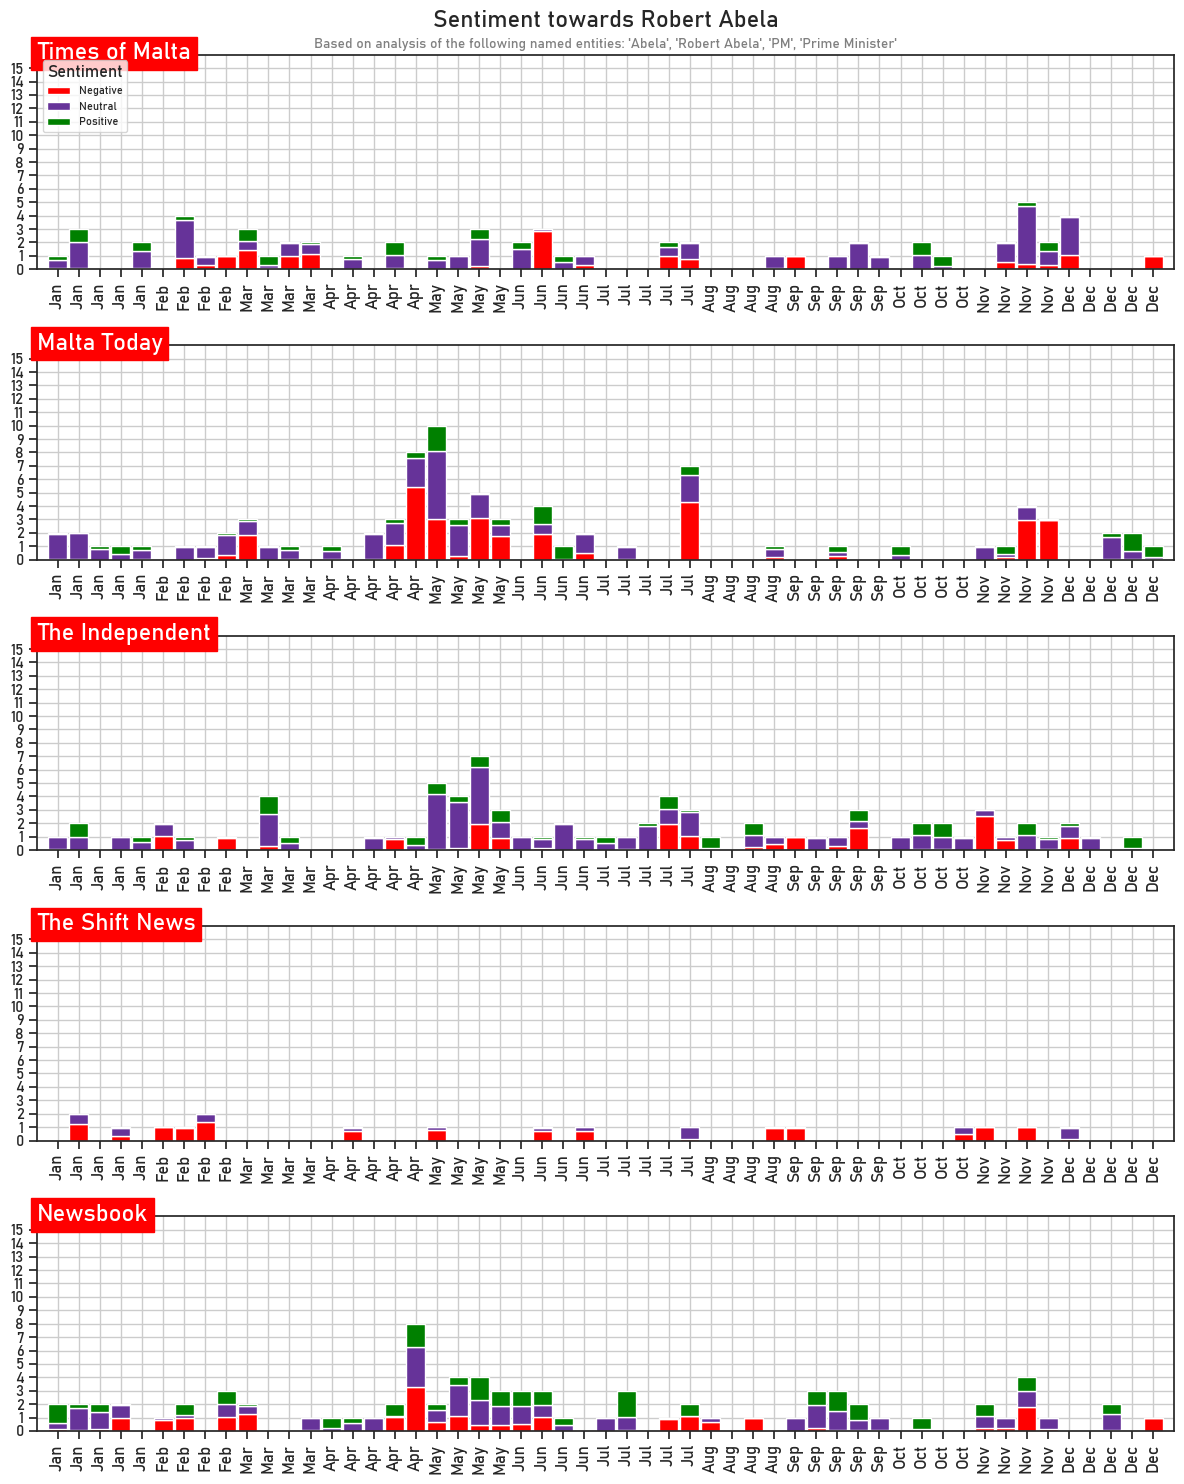

c:\Users\User\anaconda3\envs\sentiment\Lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Processing batches: 100%|██████████| 149/149 [00:04<00:00, 35.00batch/s]


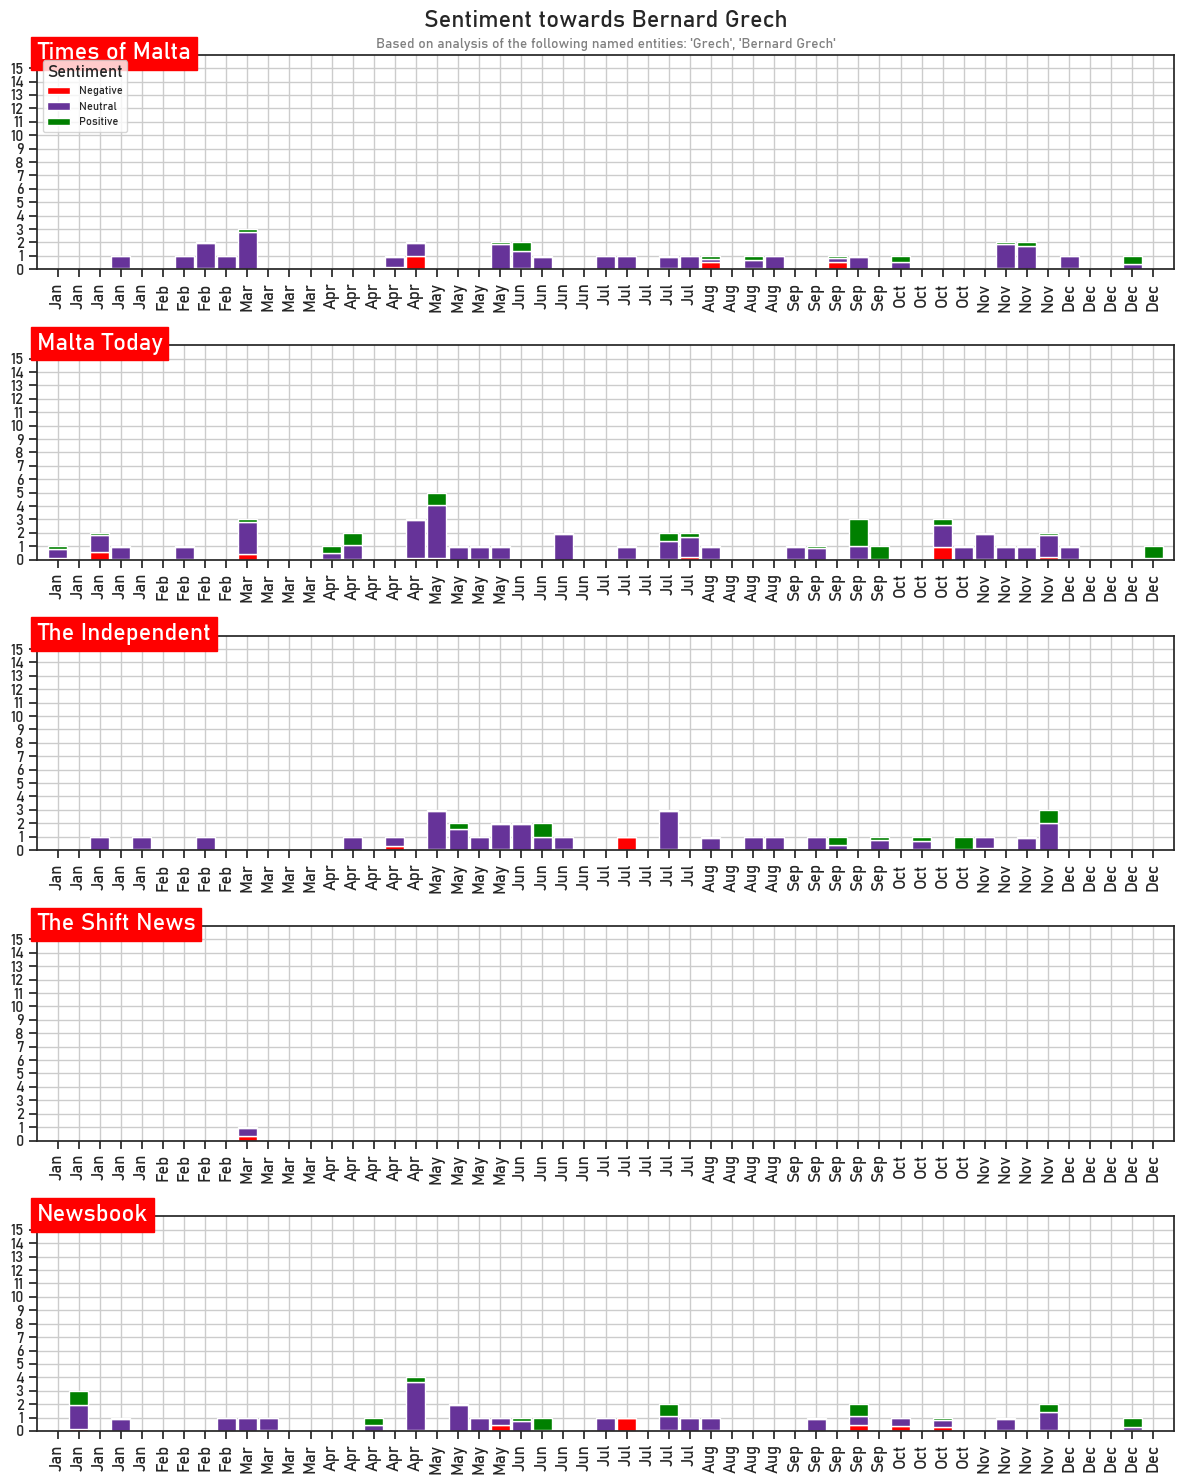

c:\Users\User\anaconda3\envs\sentiment\Lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Processing batches: 100%|██████████| 69/69 [00:01<00:00, 35.34batch/s]


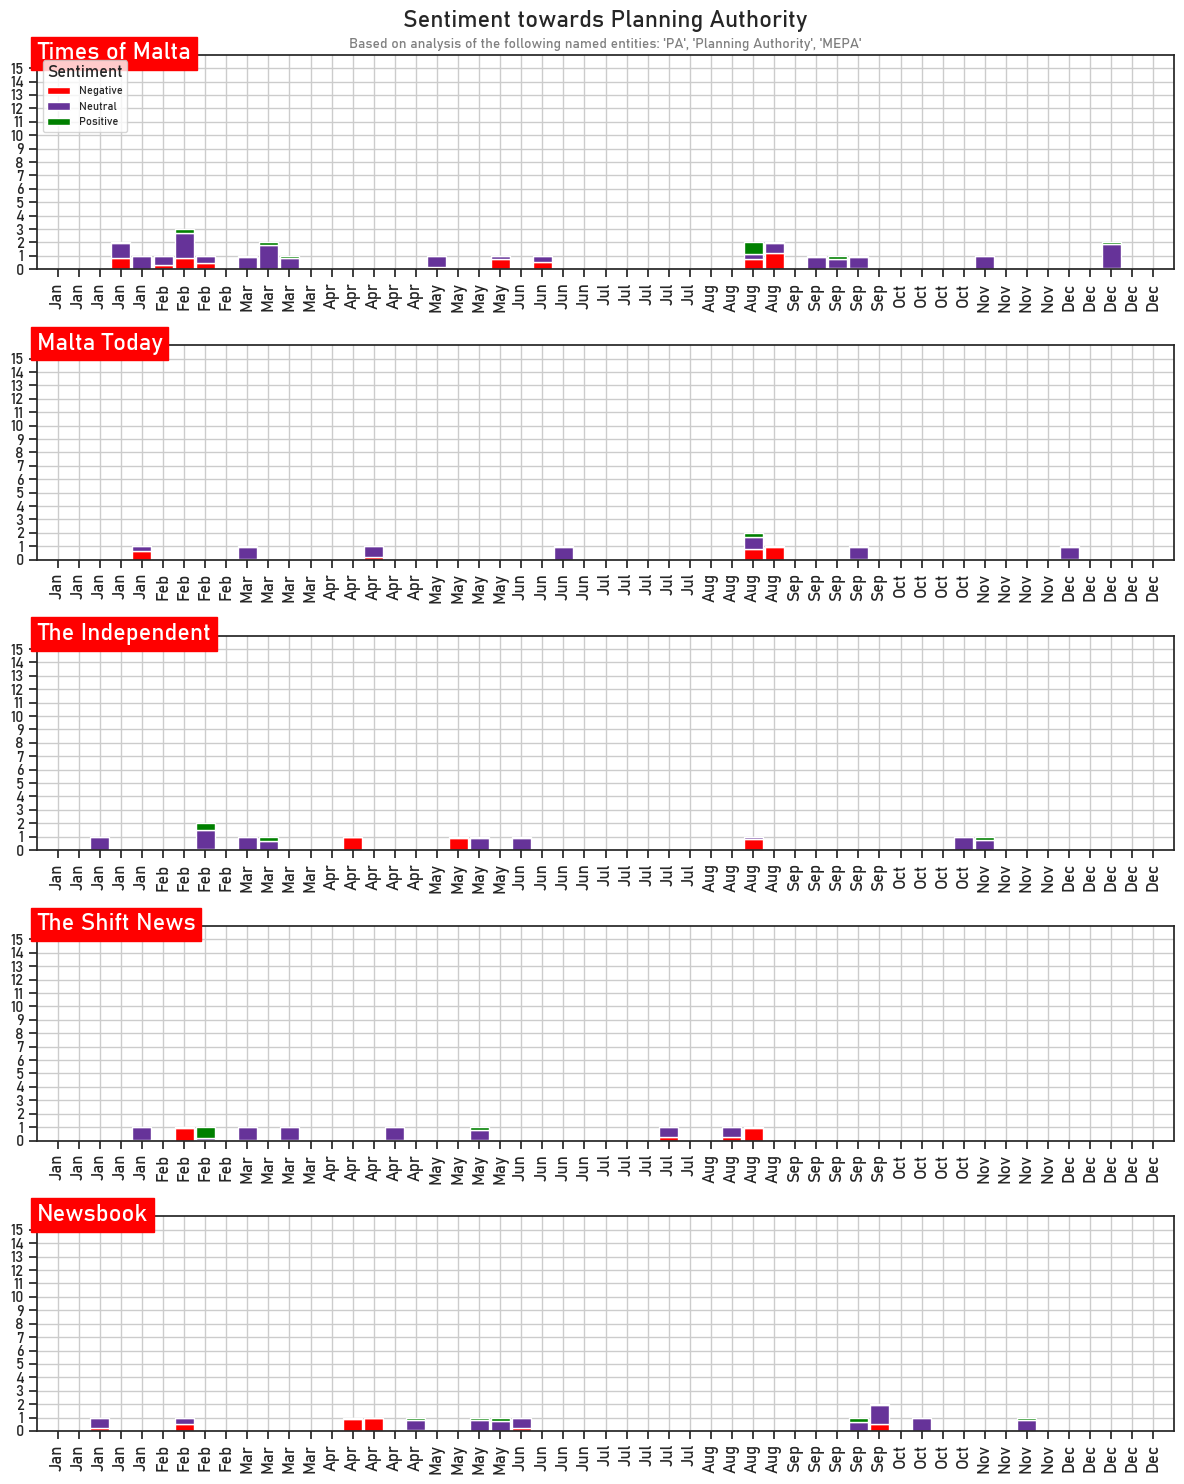

In [6]:
get_grouped_sentiment(
    targets=["Abela", "Robert Abela", "PM", "Prime Minister"],
    target_name="Robert Abela"
)

get_grouped_sentiment(
    targets=["Grech","Bernard Grech"],
    target_name="Bernard Grech"
)

get_grouped_sentiment(
    targets=["PA","Planning Authority","MEPA"],
    target_name="Planning Authority"
)
